In [10]:
DATA_DIR = 'D:/DeepLearning/PyTorch/DiseaseDetection/data'

# Transforming data

In [11]:
import torch, torchvision
from torchvision import datasets, transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(degrees=10),
    # transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    # transforms.RandomInvert(p=0.5),
    # transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size = (128, 128)),
    transforms.ToTensor()
])

In [93]:
train_dir = DATA_DIR+'/train'
test_dir = DATA_DIR+'/test'

In [94]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = train_transform, target_transform=None)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = test_transform, target_transform=None)

In [95]:
print(f'train data : {train_data}')
print()
print(f'test data : {test_data}')

train data : Dataset ImageFolder
    Number of datapoints: 1936
    Root location: D:/DeepLearning/PyTorch/DiseaseDetection/data/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

test data : Dataset ImageFolder
    Number of datapoints: 216
    Root location: D:/DeepLearning/PyTorch/DiseaseDetection/data/test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [96]:
class_names = train_data.classes
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [97]:
class_dict = train_data.class_to_idx
class_dict

{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

# Data loader

In [98]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size = 32, shuffle = True, num_workers = os.cpu_count())
test_dataloader = DataLoader(test_data, batch_size = 32, shuffle = False, num_workers = os.cpu_count())

len(train_dataloader), len(test_dataloader)

(61, 7)

In [99]:
def accuracy_func(y_true, y_pred):

    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Train function

In [174]:
from torch import nn
from tqdm.auto import tqdm
from timeit import default_timer as timer


def train_model(model, dataloader, loss, optimizer, accuracy, epoch):

    train_start_time = timer()
    model.train()

    for i in tqdm(range(epoch)):
        train_loss, train_accuracy = 0, 0

        for batch, (X, y) in enumerate(dataloader):

            # prediction of model
            y_pred = model(X)
           # print(y.shape, y_pred.shape)

            # calculating loss
            train_loss = loss(y_pred, y)

            # for every batch, accumulating only values to train_loss to get overall loss over all batches
            train_loss = train_loss + train_loss.item()

            # gradients to zero
            optimizer.zero_grad()

            # backpropagating
            train_loss.backward()

            # updating weights after backpropagation
            optimizer.step()

            train_acc = accuracy(y, y_pred.argmax(dim=1))
            train_accuracy = train_accuracy + train_acc
            
        train_loss = train_loss / len(dataloader)
        train_accuracy = train_accuracy / len(dataloader)

        print(f'\nEpoch : {i} | train accuracy : {train_accuracy} | train loss : {train_loss}')

    train_end_time = timer() - train_start_time
    print(f'\ntrain ended in : {train_end_time}')

In [175]:
# test_acc_list = []
# test_loss_list = []

def test_model(model, dataloader, loss_fn, accuracy_fn):
    test_loss, test_accuracy = 0, 0

    # putting model to evaluation mode to speed up prediction
    model.eval()
    with torch.inference_mode():
        for batch, (X_test, y_test) in enumerate(dataloader):
            test_pred = model(X_test)

            print(y_test.shape, test_pred.shape)
            loss = loss_fn(test_pred, y_test)
            test_loss = test_loss + loss.item()
            # test_loss_list.append(test_loss)
            # Calculate and accumulate accuracy
            test_acc = accuracy_fn(y_test, test_pred.argmax(dim=1))
            test_accuracy = test_accuracy + test_acc
            
        test_loss /= len(dataloader)
        test_accuracy /= len(dataloader)
        print(f'test accuracy : {test_accuracy} | test loss : {test_loss}\n')

    # return {'model_name' : model.__class__.__name__,
    #        'model_loss' : loss_fn.item(),
    #    

In [176]:
# test_model(model_1, test_dataloader, accuracy_func, loss_1)

In [177]:
class DiseaseDetector_1(nn.Module):

    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape, out_channels = hidden_units, kernel_size = 3, stride = 1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units),
            nn.MaxPool2d(kernel_size = 2, stride = 1)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units*125*125, out_features = output_shape)
        )

    def forward(self, x):
         x = self.conv_block_1(x)
        # print(x.shape)
         x = self.classifier(x)
         return x

In [178]:
model_1 = DiseaseDetector_1(input_shape = 3, hidden_units=3, output_shape=len(train_data.classes))
model_1

DiseaseDetector_1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=46875, out_features=3, bias=True)
  )
)

In [179]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_1) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Param #
DiseaseDetector_1                        --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       84
│    └─ReLU: 2-2                         --
│    └─BatchNorm2d: 2-3                  6
│    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
│    └─Flatten: 2-5                      --
│    └─Linear: 2-6                       140,628
Total params: 140,718
Trainable params: 140,718
Non-trainable params: 0

# Defining loss and optimizer

In [180]:
loss_1 = nn.CrossEntropyLoss()
optim_1 = torch.optim.Adam(model_1.parameters(), lr = 0.002)

In [181]:
torch.manual_seed(42)

train_model(model_1, train_dataloader, loss_1, optim_1, accuracy_func, 10)

  0%|          | 0/10 [00:00<?, ?it/s]


Epoch : 0 | train accuracy : 73.51434426229508 | train loss : 0.014365853741765022

Epoch : 1 | train accuracy : 83.60655737704919 | train loss : 0.04304688796401024

Epoch : 2 | train accuracy : 89.9077868852459 | train loss : 0.005443120375275612

Epoch : 3 | train accuracy : 90.21516393442623 | train loss : 0.009090904146432877

Epoch : 4 | train accuracy : 94.51844262295081 | train loss : 0.010834908112883568

Epoch : 5 | train accuracy : 93.13524590163935 | train loss : 0.012112084776163101

Epoch : 6 | train accuracy : 96.46516393442623 | train loss : 0.003410981735214591

Epoch : 7 | train accuracy : 96.72131147540983 | train loss : 1.1620282748481259e-05

Epoch : 8 | train accuracy : 98.87295081967213 | train loss : 0.00020152218348812312

Epoch : 9 | train accuracy : 99.12909836065573 | train loss : 4.7636008275731e-06

train ended in : 610.9098223999608


In [182]:
test_data_path = list(Path(test_dir).glob('*/*.JPG'))
test_data_path[:4]

[WindowsPath('D:/DeepLearning/PyTorch/DiseaseDetection/data/test/Potato___Early_blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG'),
 WindowsPath('D:/DeepLearning/PyTorch/DiseaseDetection/data/test/Potato___Early_blight/03b0d3c1-b5b0-48f4-98aa-f8904670290f___RS_Early.B 7051.JPG'),
 WindowsPath('D:/DeepLearning/PyTorch/DiseaseDetection/data/test/Potato___Early_blight/0604174e-3018-4faa-9975-0be32d2c0789___RS_Early.B 7123.JPG'),
 WindowsPath('D:/DeepLearning/PyTorch/DiseaseDetection/data/test/Potato___Early_blight/096a2c48-104c-4570-9e34-8dd60aa5ebcf___RS_Early.B 6979.JPG')]

In [183]:
def pred_and_store(paths, model, transform, class_names):

    pred_list = []
    for path in tqdm(paths):
        
        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        pred_dict['image_path'] = path
        class_name = path.parent.stem
        pred_dict['class_name'] = class_name

        start_time = timer()

        img = Image.open(path)
        transformed_image = transform(img).unsqueeze(0)

        model.eval()

        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label]

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

             # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)
        
    return pred_list

In [184]:
model_pred = pred_and_store(test_data_path, model_1, test_transform, class_names)

  0%|          | 0/216 [00:00<?, ?it/s]

In [185]:
# import pandas as pd

# model_test_pred_df = pd.DataFrame(model_pred)
# tinyvgg_test_pred_df[tinyvgg_test_pred_df['correct'] == True].shape
model_test_pred_df.sample(4)

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
31,D:\DeepLearning\PyTorch\DiseaseDetection\data\...,Potato___Early_blight,1.0000,Potato___Early_blight,0.0106,True
27,D:\DeepLearning\PyTorch\DiseaseDetection\data\...,Potato___Early_blight,1.0000,Potato___Early_blight,0.0157,True
104,D:\DeepLearning\PyTorch\DiseaseDetection\data\...,Potato___healthy,0.9987,Potato___Late_blight,0.0109,False
207,D:\DeepLearning\PyTorch\DiseaseDetection\data\...,Potato___Late_blight,1.0000,Potato___Late_blight,0.0107,True


In [186]:
model_test_pred_df['correct'].value_counts()

correct
True     179
False     37
Name: count, dtype: int64

In [187]:
y_preds = []
model_1.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc = 'making predictions'):
    y_logits = model_1(X)
    y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred)

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:5]

making predictions:   0%|          | 0/7 [00:01<?, ?it/s]

tensor([2, 0, 2, 0, 1])

In [188]:
# try:
#     import torchmetrics
# except:
#     !pip install torchmetrics
#     import torchmetrics

In [189]:
# try:
#     import mlxtend
# except:
#     !pip install mlxtend
#     import mlxtend

In [190]:
import numpy as np
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

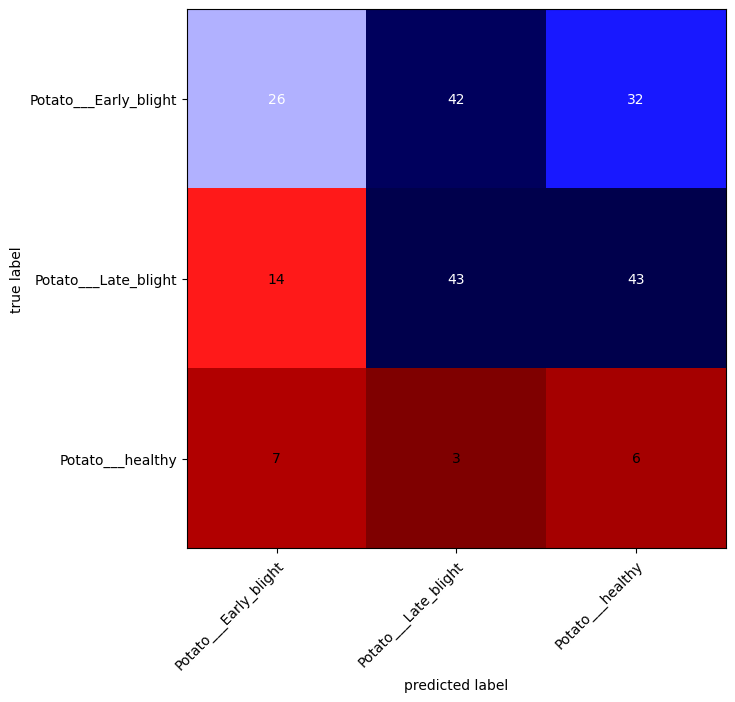

In [191]:
confmat = ConfusionMatrix(task="multiclass", num_classes = 3)
cm = confmat(y_pred_tensor, torch.tensor(test_data.targets))

fig, ax = plot_confusion_matrix(conf_mat = cm.numpy(),
                                class_names = class_names,
                                figsize=(10, 7), cmap = 'seismic_r')

In [192]:
from torchmetrics.classification import MulticlassPrecision
mcp = MulticlassPrecision(num_classes=3)
mcp(y_pred_tensor, torch.tensor(test_data.targets))

tensor(0.3720)

In [193]:
model_path = DATA_DIR + '/models'
torch.save(model_1, model_path)

In [157]:
model_1_scripted = torch.jit.script(model_1) # Export to TorchScript
model_1_scripted.save('model_1_scripted.pt') # Save

# Loading model
model = torch.jit.load('model_1_scripted.pt')
model.eval()

RecursiveScriptModule(
  original_name=DiseaseDetector_1
  (conv_block_1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=BatchNorm2d)
    (3): RecursiveScriptModule(original_name=MaxPool2d)
  )
  (classifier): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Flatten)
    (1): RecursiveScriptModule(original_name=Linear)
  )
)